# Using Correlated-K Tables vs. Monochromatic Opacities

Throughout the tutorials, we have always used monochromatic opacities. If you are interested in switching to correlated-K tables versus using the currently provided opacities on Zenodo, that is possible. We currently supporting pre-mixed correlated-k-tables that you can find  on [Zenodo]() and details are included in [Marley et al. 2020](https://ui.adsabs.harvard.edu/abs/2021ApJ...920...85M/abstract), as well as new resorted correlated-k opacities. 

Before completing this notebook you will have to: 

1. [Download at least one or multiple of the k-table folder](https://zenodo.org/record/5590989#.Yzy1qezMJb9)
    File should be of the format `sonora_2020_feh+XXX_co_YYY`, where XXX defines the Fe/H and YYY describes the C/O ratio. **Inside that directory there should be at least two files: ascii_data, and full_abunds**


2. [Download Sonora PT profiles](https://zenodo.org/record/1309035#.Y1MHYezMLvW) (if this is unfamiliar please see [Brown Dwarf Tutorial](https://natashabatalha.github.io/picaso/notebooks/6_BrownDwarfs.html))

3. [Download PICASO Correlated-K's for On-the-Fly Disequilibrium Climate Calculations
](https://zenodo.org/records/10895826) (see [Brown Dwarf Tutorial](https://natashabatalha.github.io/picaso/notebooks/climate/12a_BrownDwarf.html))

In [1]:
from pathlib import Path
import os
import sys

# Make sure you have an enviromental path defined
picaso_refdata_str = os.environ.get('picaso_refdata')

# You can also defined the necessary paths this way
#os.environ['picaso_refdata'] = 'your_path' #THIS MUST GO BEFORE YOUR IMPORT STATEMENT
#os.environ['PYSYN_CDBS'] = 'your_path' #this is for the stellar data discussed below.

# Set the relative file paths
base_path = Path(picaso_refdata_str)
pysyn_cdbs_path = base_path / 'grp' / 'redcat' / 'trds'
ck_db_path = base_path / 'sonora_2020_feh+000_co_100.data.196/'
sonora_profile_db_path = base_path / 'sonora_profile/'

In [2]:
from picaso import justdoit as jdi 
from picaso import justplotit as jpi
jpi.output_notebook()

import matplotlib.pyplot as plt
from itertools import cycle
from matplotlib.lines import Line2D
import numpy as np

/Users/imalsky/Documents/picaso/picaso/justdoit.py:55: UserWarning: Your code version is 3.3 but your reference data version is 4.0. For some functionality you may experience Keyword errors. Please download the newest ref version or update your code: https://github.com/natashabatalha/picaso/tree/master/reference
  warnings.warn(f"Your code version is {__version__} but your reference data version is {ref_v}. For some functionality you may experience Keyword errors. Please download the newest ref version or update your code: https://github.com/natashabatalha/picaso/tree/master/reference")


Loading BokehJS ...

In [3]:
opacity_mono         = jdi.opannection()
opacity_ck           = jdi.opannection(ck_db=str(ck_db_path),
                                       method='preweighted')

# This requires the climate_INPUTS directory, and associated data
# See https://natashabatalha.github.io/picaso/notebooks/climate/12c_BrownDwarf_DEQ.html
# They should be in the references dir
gases_fly = ['CO','CH4','H2O','NH3','CO2','N2','HCN','H2','PH3','C2H2','Na','K','TiO','VO','FeH']
opacity_resortrebin =  jdi.opannection(method='resortrebin',
                                       preload_gases=gases_fly)

/Users/imalsky/Documents/picaso/picaso/optics.py:1410: UserWarning: Warning: npy files for DEQ will be deprecated in a future PICASO udpate. Please download the hdf5 files, explanation here https://natashabatalha.github.io/picaso/notebooks/climate/12c_BrownDwarf_DEQ.html
  warnings.warn(' '.join(np.unique(msg)), UserWarning)


## Call `opannection` and supply a correlated-k table

Notice that when we call the `opannection` with the `ck=True`, we must also pass it one of the directories from Zenodo. The directory name describes the chemistry that this has been calculated for. The `ck_db` we have defined  is for 1xSolar, Solar C/O. 



In [4]:
# Lets use the same example Jupiter PT profile
pt = jdi.pd.read_csv(jdi.jupiter_pt(), sep='\s+',usecols=[0,1])

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/8_/lltwgz4x48ncx3q3k86fr_tm0000gq/T/ipykernel_31861/40400509.py:2: SyntaxWarning: invalid escape sequence '\s'
  pt = jdi.pd.read_csv(jdi.jupiter_pt(), sep='\s+',usecols=[0,1])


You should already be familiar with the following code block. Here we are loading the input class, setting the gravity, stellar parameters, and sonora profile. 

In [5]:
# Create a dictionary that contains all the different calc types
calc = {'ck':opacity_ck,
        'mono':opacity_mono,
        'resort':opacity_resortrebin}
cases = {i: jdi.inputs() for i in calc.keys()}

# Phase angle 
for i in calc.keys(): cases[i].phase_angle(0) #radians

# Define gravity
for i in calc.keys(): cases[i].gravity(radius=1, 
                                    radius_unit=jdi.u.Unit('R_jup'),
                                    mass=1,
                                    mass_unit=jdi.u.Unit('M_jup'))

# Define star 
for i in calc.keys(): cases[i].star(calc[i],
                                    5000,
                                    0,
                                    4.0,
                                    radius=1,
                                    radius_unit=jdi.u.Unit('R_sun'),
                                    semi_major=5,
                                    semi_major_unit=jdi.u.Unit('au')) 
    

# Just grabbing any Teff so we can use a sonora pressure-temperature profile
Teff = 1000
for i in calc.keys():cases[i].sonora(str(sonora_profile_db_path), Teff, chem='grid')

The differences between the two procedures comes in when we specify the chemistry. Here we introduce a new function called `premix_atmosphere`. This is going to pull the precomputed chemistry that was used to compute the correlated k tables. 

In [6]:
# Figure out here from fun with chem
cases['ck'].premix_atmosphere(calc['ck'])

# Now let's pass that to the monochromatic opacities for consistency
cases['mono'].atmosphere(df=cases['ck'].inputs['atmosphere']['profile'])

# Set identical atmosphere for the resorted ck, if desired.
#cases['resort'].atmosphere(df=cases['ck'].inputs['atmosphere']['profile'])

In [7]:
df = {}

# Run picaso with each of the cases
df['ck'] = cases['ck'].spectrum(calc['ck'],full_output=True, calculation='thermal')
df['mono'] = cases['mono'].spectrum(calc['mono'],full_output=True, calculation='thermal')
df['resort'] = cases['resort'].spectrum(calc['resort'],full_output=True, calculation='thermal')

## Compare the optical depth for various layers

One big difference you will notice between `taugas` for a monochromatic opacity calculation and a correlated-k calculation, is that `taugas` will have an extra dimension for CK. Those correspond to each of the gauss points. Now, be careful not to confuse the gauss points that we use for the disk integration and these gauss points. They are different!

Below is an example of summing the `tau`'s in order to compare with the monochromatic opacities. 

This compares the mono case, the premixed correlated-k case, and the disequilibrium chemistry correlated-k case

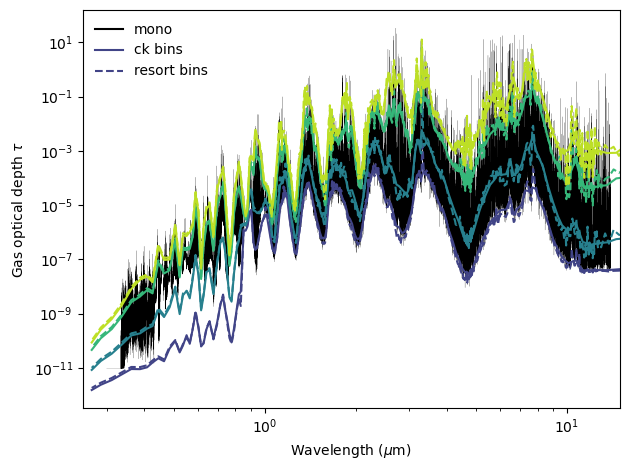

In [8]:

cm1_to_micron = lambda wn: 1e4 / wn 

# Num guass points is based on the opacities that you're using
num_gauss_points = 8
gauss_to_plot    = range(0, num_gauss_points, 2)  
cmap             = plt.cm.viridis
colors           = cmap(np.linspace(0.2, 0.9, len(gauss_to_plot)))

wl_mono  = cm1_to_micron(df['mono']['wavenumber'])
wl_ck    = cm1_to_micron(df['ck']['wavenumber'])
wl_resort = cm1_to_micron(df['resort']['wavenumber'])

fig, ax = plt.subplots()

ax.plot(wl_mono,
        df['mono']['full_output']['taugas'][0],
        color='black', lw=0.1, alpha=1, label='mono')

# CK = solid, resort = dashed; color varies per Gauss index
for j, i in enumerate(gauss_to_plot):
    clr = colors[j]
    ax.plot(wl_ck,    df['ck']['full_output']['taugas'][0, :, i], lw=1.5, ls='-', color=clr)
    ax.plot(wl_resort, df['resort']['full_output']['taugas'][0, :, i], lw=1.5, ls='--', color=clr)

# axes formatting
ax.set(xscale='log', yscale='log',
       xlim=(0.25, 15),
       xlabel=r'Wavelength ($\mu$m)',
       ylabel=r'Gas optical depth $\tau$')

# legend with uniform linewidth
leg_lw = 1.5
legend_handles = [
    Line2D([], [], color='black',  lw=leg_lw, ls='-',  label='mono'),
    Line2D([], [], color=colors[0], lw=leg_lw, ls='-',  label='ck bins'),
    Line2D([], [], color=colors[0], lw=leg_lw, ls='--', label='resort bins'),
]
ax.legend(handles=legend_handles, frameon=False)

plt.tight_layout()
plt.show()

## Compare Chemistry

In this case we supplied it the same chemistry. However, there may be cases where you want to extract the chemistry from the pre-computed files. This is how you would go about doing so. 

For the below code snippet, I am pulling out the abundances that are higher than 0.1 ppm. 

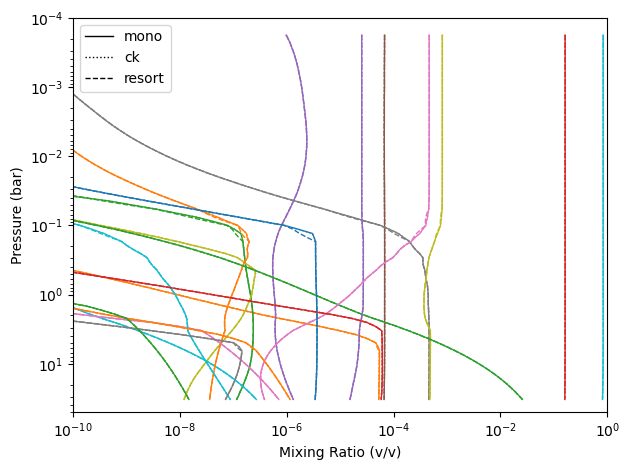

In [9]:
styles = {'mono': '-', 'ck': ':', 'resort': '--'}
colors = cycle(plt.cm.tab10.colors)

fig, ax = plt.subplots()
ax.set(xscale='log', yscale='log', xlim=(1e-10, 1), ylim=(50, 1e-4), xlabel='Mixing Ratio (v/v)', ylabel='Pressure (bar)')

species = {c for k in styles for c in cases[k].inputs['atmosphere']['profile'].columns if c not in ('pressure', 'temperature')}

for clr, sp in zip(colors, species):
    for case, ls in styles.items():
        df = cases[case].inputs['atmosphere']['profile']
        x = df.get(sp)
        if x is not None and x.max() > 1e-8:
            ax.plot(x, df['pressure'], color=clr, ls=ls, lw=1)

ax.legend([Line2D([], [], color='k', lw=1, ls=ls) for ls in styles.values()], styles.keys())
plt.tight_layout()